In [1]:
# 1 데이터셋 불러오기
import pandas as pd
df = pd.read_csv('insult_path')  # 파일 불러오기
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)
print(df.info())

                               reviewId          userName  \
0  4f8e23e8-860d-4cf2-8a07-0735e9e94dac       Eddy Wijaya   
1  b36f1a48-1ac6-4dc0-a895-50a520205fef  Tirthesh Poojari   
2  61ec00cf-0ced-4d96-98b5-b67cde1d4c83     Trupti Ambade   
3  1a05f4ef-ff9e-46cb-948b-4bd3a27d5d53        Sanju Sahu   
4  cb98f179-4996-445e-a896-f49313a8c84b      Billy Barras   

                                             content  score  thumbsUpCount  \
0                                         Can't open      1              0   
1                          The best app😍😍😍😍😍😍😍😍😍😍😍😍😍      5              0   
2  Most of the famous Korean drama are not dubbed...      2              0   
3  It's superb but can you please add comments se...      5              0   
4  The only reason I didn't give it four stars is...      1              0   

    reviewCreatedVersion                   at             appVersion  
0                    NaN  2024-10-19 14:23:00                    NaN  
1                    N

In [2]:
# 2 데이터 전처리
# 결측치 처리
df[df['userName'].isnull()]   # userName 열의 결측치 확인하기
df['userName'] = df['userName'].fillna('anonymous')   # userName 열의 결측치를 anonymous로 채우기

print(df['score'].min())   # score 최솟값 확인하기
print(df['score'].max())   # score 최댓값 확인하기

df[df['content'].isnull()]   # content 열의 결측치 확인하기
# content 열에 결측치가 있는 경우 score에 따라 내용을 채우는 함수 생성하기
def content_filled(row):
    if pd.isnull(row['content']):
        if row['score'] == 5:
            return 'I love it.'
        elif row['score'] == 4:
            return 'I like it.'
        elif row['score'] == 3:
            return 'So-so.'
        elif row['score'] == 2:
            return 'Not good.'
        elif row['score'] == 1:
            return 'Bad.'
    else:
        return row['content']

# content 열의 결측치 처리하기
df['content'] = df.apply(content_filled, axis=1)

df[df['reviewCreatedVersion'].isnull()]   # 결측치 확인하기
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].ffill()   # ffill() : 결측값을 바로 위 값과 동일하게 변경한다.

df[df['appVersion'].isnull()]   # appVersion 열의 결측치 확인하기
df['appVersion'] = df['appVersion'].ffill()   # ffill로 결측치 채우기

df.isnull().sum()

1
5


reviewId                0
userName                0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    2
at                      0
appVersion              2
dtype: int64

In [3]:
# 중복값 확인
df[df.duplicated()]    # 중복값 확인하기
df = df.drop_duplicates(keep='first')    # 중복값 제거하기
df.duplicated().sum()    # 중복값이 잘 제거됐는지 확인하

0

In [4]:

# 불용어 처리
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
additional_stopwords = {'app', 'netflix', 'show', 'time', 'series', 'phone', 'movie', 'tv', 'would', 'watch'}
stop_words = stop_words.union(additional_stopwords)
stop_words.discard('not')

# 표제어 추출
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
# 동사 원형
def lemma_v(sentence):
    return [lemmatizer.lemmatize(word, 'v') for word in sentence]
# 명사 원형
def lemma_n(sentence):
    return [lemmatizer.lemmatize(word, 'n') for word in sentence]

# 토큰화
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
def TagFitter(sentense):
  tokens = pos_tag(word_tokenize(sentense))
  tags = [t[0] for t in tokens if t[1] != "NNP" and t[1] != "NNPS" and t[1] != "PRP" and t[1] != "DT"]
  return ' '.join(tags)

# 단어 대체 - 't 를 not으로 변환
def t_replacer(sentense):
  tokens = word_tokenize(sentense)
  r = []
  for token in tokens:
    if token == 't': 
      r.append('not')
    else: 
      r.append(token)
  return ' '.join(r)

# 철자 교정
from textblob import TextBlob
def WordCorrect(senntense):
  s = TextBlob(senntense)
  s = s.correct()
  s = ''.join(s)
  # s = pd.Series(s)
  return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yeongung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yeongung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# 전처리 함수 - 기능 취사선택
def preprocessing(sentence):
  if isinstance(sentence, float): return ''
  cleaned = re.sub('[^a-zA-Z]', ' ', sentence)
  # cleaned = t_replacer(cleaned)
  # cleaned = TagFitter(cleaned)
  cleaned = cleaned.lower()
  cleaned = cleaned.strip()
  cleaned = cleaned.split()
  cleaned = lemma_v(cleaned)
  cleaned = lemma_n(cleaned)
  # cleaned = [word for word in cleaned if word not in stop_words]
  cleaned = ' '.join(cleaned)
  # cleaned = WordCorrect(cleaned)
  return cleaned

In [6]:
reviews = df['content']
ratings = df['score']
if len(reviews) != len(ratings):
    print("warning: do not match")

In [7]:
reviews = reviews.apply(preprocessing)

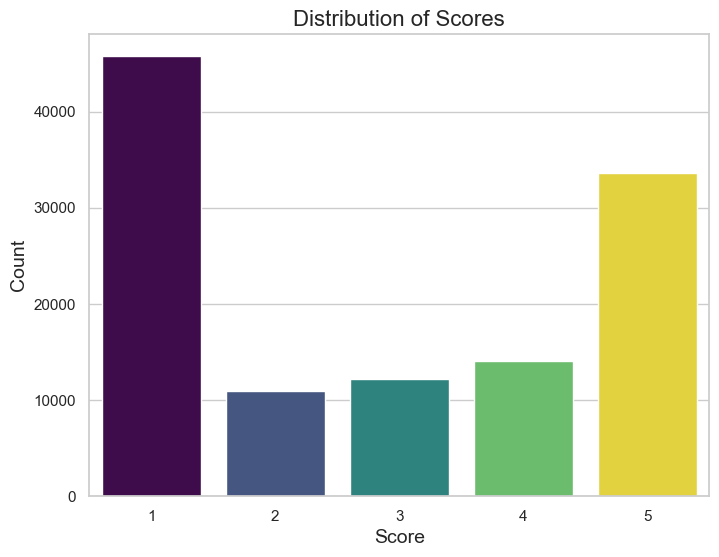

In [8]:
# 3 feature 분석
import seaborn as sns
import matplotlib.pyplot as plt
# 그래프 스타일 설정
sns.set(style='whitegrid')

# 점수의 빈도 수를 계산하여 데이터프레임으로 변환
score_counts = df['score'].value_counts().reset_index()
score_counts.columns = ['score', 'count']

plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.barplot(x='score', y='count', data=score_counts, hue='score', palette='viridis', legend=False)    # 막대 그래프 그리기

# 점수의 빈도 수 계산:
# value_counts(): 이 메서드는 지정된 열의 고유한 값과 그 빈도를 계산하여 반환하는 시리즈 객체이다.
# df['score'].value_counts(): 각 점수의 빈도를 계산한다.
# .reset_index(): 인덱스를 초기화하여 새로운 데이터프레임으로 변환한다.
# score_counts.columns = ['score', 'count']: reset_index로 초기화한 열 이름을 다시 지정한다.

# 그래프 제목 및 축 레이블 추가
plt.title('Distribution of Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)

# 그래프 출력
plt.show()

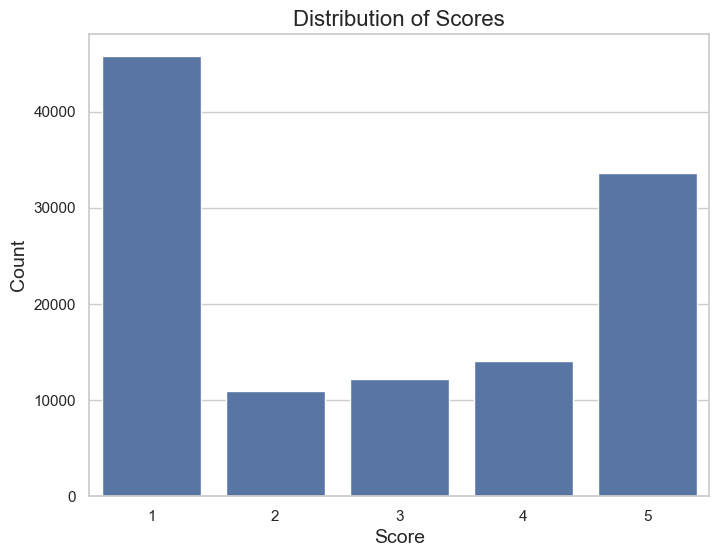

In [9]:
# 만약 hue 매개변수가 필요 없는 경우, 그냥 palette를 사용하지 않고 아래와 같이 간단하게 표현할 수도 있다.
# 점수 분포를 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.countplot(x='score', data=df)  # hue 없이 countplot 사용

# 그래프 제목 및 축 레이블 추가
plt.title('Distribution of Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)

# 출력
plt.show()

# 그래프 종류

1. 선 그래프 (Line Plot): 데이터를 선으로 연결한 그래프.
2. 막대 그래프 (Bar Plot): 범주형 데이터를 막대로 표현한 그래프.
3. 산점도 (Scatter Plot): 두 변수 간의 관계를 점으로 표현한 그래프.
4. 히스토그램 (Histogram): 데이터 분포를 막대의 높이로 표현한 그래프.
5. 파이 차트 (Pie Chart): 각 항목의 비율을 원형으로 표현한 그래프.
6. 상자 그림 (Box Plot): 데이터의 사분위수를 보여주는 그래프.
7. 히트맵 (Heatmap): 값의 크기를 색상으로 표현한 그래프.
8. 커널 밀도 추정 (KDE Plot): 데이터의 분포를 곡선으로 표현한 그래프.

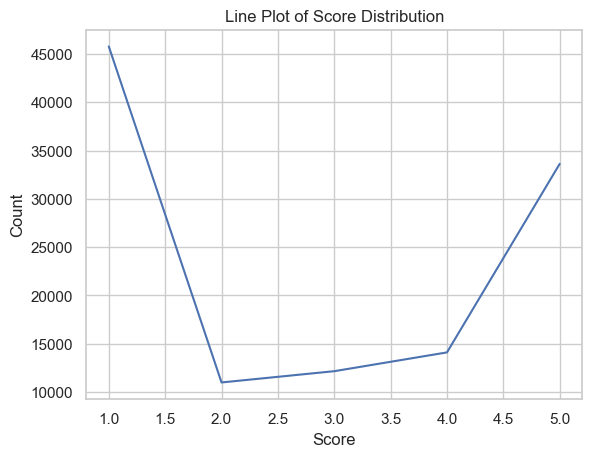

In [10]:
# 1. 선 그래프 (Line Plot) : 데이터의 빈도를 계산하여 선 그래프로 그리기

# 데이터의 빈도 계산하기
score_counting = df['score'].value_counts().sort_index()
plt.plot(score_counting.index, score_counting.values)
plt.title("Line Plot of Score Distribution")    # 그래프의 제목을 설정한다. 이 경우 "Score Distribution"이라는 제목이 그래프 상단에 표시된다.
plt.xlabel("Score")    # plt.xlabel(): x축의 레이블을 설정한다. 이 경우 x축에 "Score"라는 레이블이 붙는다.
plt.ylabel("Count")    # plt.ylabel(): y축의 레이블을 설정한다. 이 경우 y축에 "Frequency"라는 레이블이 붙다.
plt.show()


# plt와 sns 차이점

# plt.plot() (matplotlib): 기본적인 선 그래프를 그리며, 레이블, 축 설정 등을 수동으로 추가해야 한다.
# sns.lineplot() (seaborn): plt.plot()보다 더 높은 수준의 API로, 자동으로 축 레이블과 스타일링이 추가되고, DataFrame과의 통합이 더 쉽다.

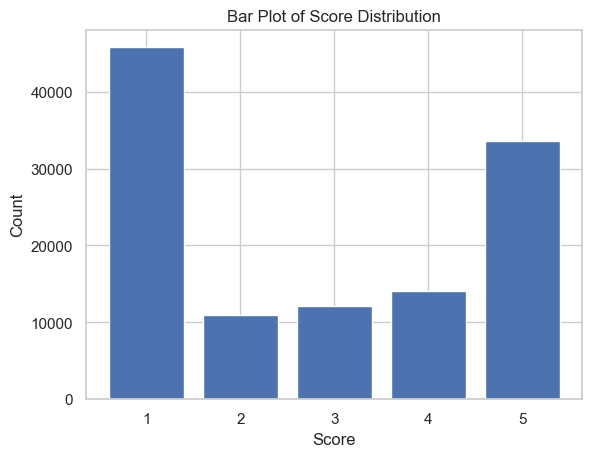

In [11]:
# 2. 막대 그래프 (Bar Plot) : 데이터의 빈도를 계산하여 막대 그래프로 그리기
# 데이터 빈도 계산하기는 선 그래프 그리기에서 이미 했기 때문에 이제부터는 생략할 것이다.

# 그래프 그리기
plt.bar(score_counting.index, score_counting.values)
plt.title("Bar Plot of Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# plt와 sns 차이점

# plt.bar() (matplotlib): 단순한 막대 그래프 그리기, 축 레이블과 스타일을 수동으로 설정해야 한다.
# sns.barplot() (seaborn): mean과 confidence interval이 자동으로 계산되어 표시되며,
# DataFrame을 쉽게 사용해 그룹별 평균을 시각화할 수 있다.

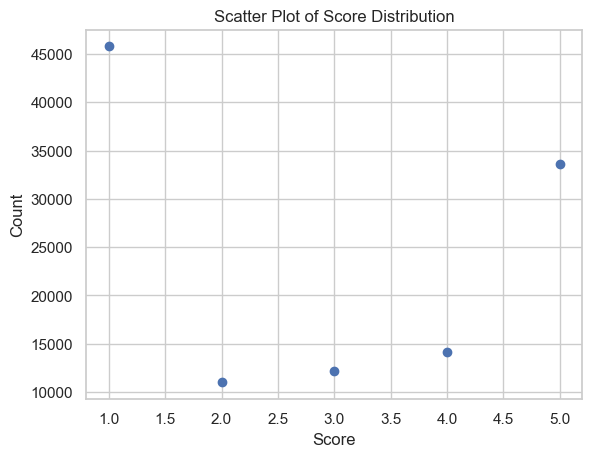

In [12]:
# 3. 산점도 (Scatter Plot) : 데이터의 빈도를 계산하여 산점도로 그리기
plt.scatter(score_counting.index, score_counting.values)
plt.title("Scatter Plot of Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# plt와 sns 차이점

# plt.scatter() (matplotlib): 산점도를 그릴 때 수동으로 색, 크기 등을 지정해야 한다.
# sns.scatterplot() (seaborn): hue, size, style 인수를 통해 카테고리별로 색깔과 모양을 자동으로 구분해준다.
# 데이터프레임과 함께 쉽게 사용 가능하다.

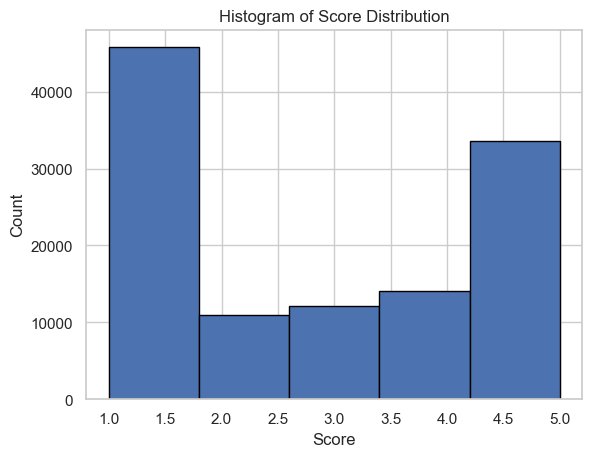

In [13]:
# 4. 히스토그램 (Histogram) : 히스토그램으로 데이터 분포 그리기
plt.hist(df['score'], bins=5, range=(1, 5), edgecolor='black')
plt.title("Histogram of Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# plt와 sns 차이점

# plt.plot() (matplotlib): 기본적인 선 그래프를 그리며, 레이블, 축 설정 등을 수동으로 추가해야 한다.
# sns.lineplot() (seaborn): plt.plot()보다 더 높은 수준의 API로, 자동으로 축 레이블과 스타일링이 추가되고, DataFrame과의 통합이 더 쉽다.

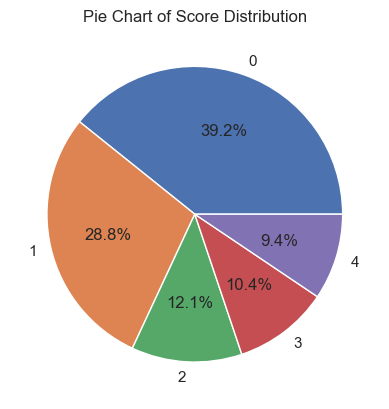

In [14]:
# 5. 파이 차트 (Pie Chart) : 데이터의 빈도를 계산하여 파이 차트로 그리기
score_counts_not_sortedindex = df['score'].value_counts()

plt.pie(score_counts_not_sortedindex, labels=score_counts.index, autopct='%1.1f%%')
plt.title("Pie Chart of Score Distribution")
plt.show()

# plt와 sns 차이점

# plt.pie(): matplotlib에서만 제공하고, 직접 수동 설정이 필요하다.
# sns: Seaborn은 파이 차트를 제공하지 않는다.

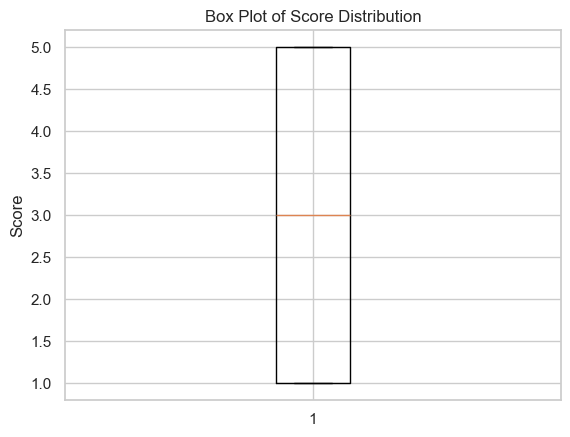

In [15]:
# 6. 상자 그림 (Box Plot) : 상자 그림으로 데이터 분포 그리기
plt.boxplot(df['score'])
plt.title("Box Plot of Score Distribution")
plt.ylabel("Score")
plt.show()

# plt와 sns 차이점
# plt.boxplot(): 한 번에 여러 개의 데이터 세트를 위치 인수로 받을 수 있다.
# sns.boxplot(): 하나의 데이터 세트만 위치 인수로 받을 수 있으며, x 또는 y를 지정해준다.
# 그러나 데이터프레임과 함께 사용하여 x와 y를 축별로 나누어 사용할 수 있다.

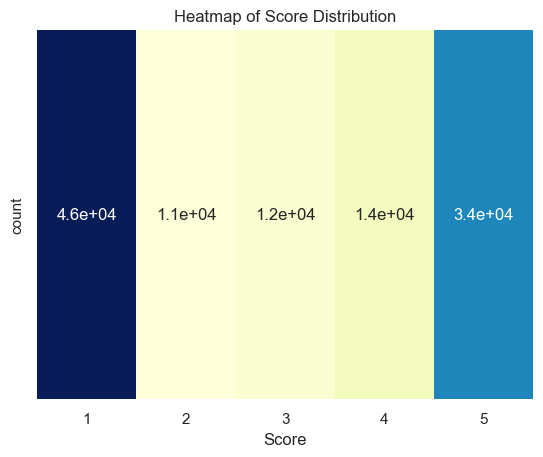

In [16]:
# 7. 히트맵 (Heatmap) ; 이 경우 범주형 데이터이므로 빈도에 대한 히트맵
# 점수별 빈도를 데이터프레임으로 변환
score_counts_frame = df['score'].value_counts().sort_index().to_frame().T

# 히트맵 그리기
sns.heatmap(score_counts_frame, annot=True, cmap="YlGnBu", cbar=False)
plt.title("Heatmap of Score Distribution")
plt.xlabel("Score")
plt.show()

# plt와 sns 차이점

# plt.imshow(): 이미지 또는 행렬 데이터를 단순히 시각화하는 데 적합하고,
#               데이터프레임 통합이 어렵고, 수동 설정이 많다.
# sns.heatmap(): 데이터프레임과의 통합이 매우 쉽고, 상관 행렬 등의 시각화에 유용하며,
#                자동화된 스타일링을 제공한다.

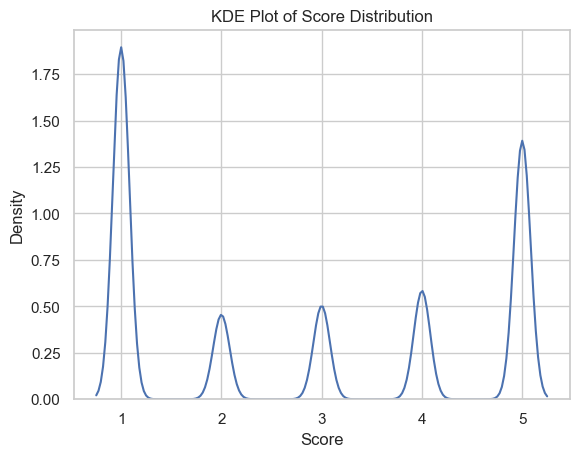

In [17]:
# 8. 커널 밀도 추정 (KDE Plot) : KDE 플롯으로 데이터 분포 그리기
sns.kdeplot(df['score'], bw_adjust=0.5)
plt.title("KDE Plot of Score Distribution")
plt.xlabel("Score")
plt.ylabel("Density")
plt.show()

# plt와 sns 차이점

# plt.plot()과 scipy.stats.kde() (matplotlib): 커널 밀도 추정을 수동으로 계산하고 그려야 한다.
# sns.kdeplot() (seaborn): kde 그래프를 간단히 그릴 수 있으며,
#                          여러 카테고리나 변수를 쉽게 시각화할 수 있다.

In [18]:
# # 테스트용
# reviews = reviews[0:5000]
# ratings = ratings[0:5000]

In [19]:
# 4 리뷰 예측 모델 학습시킥기(LSTM) - 데이터 전처리 - 시퀀스 데이터 변환
import torch
from tensorflow.keras.preprocessing.text import Tokenizer 
tokenizer = Tokenizer(oov_token='<OOV>') # 없는 데이터 치환
tokenizer.fit_on_texts(reviews) # 단어집 생성
len(tokenizer.word_index) # 단어집 개수

from tensorflow.keras.preprocessing.sequence import pad_sequences
reviews = tokenizer.texts_to_sequences(reviews)
# 원활한 학습을 위해 크기를 맞춤
MAX_LENGTH = 50 # 최대 문장의 길이
TRUNC = 'post' # 넘칠 경우 자르기 / 앞부분 = pre, 뒷부분 = post
PAD = 'post' # 모자랄 경우 채우기(0) / 위와 같음
reviews = pad_sequences(reviews, maxlen= MAX_LENGTH, truncating = TRUNC, padding = PAD)
reviews.shape

(5000, 50)

# TorchText 예시
```Py
from torchtext.data.utils import get_tokenizer # 토큰화 모듈
from torchtext.vocab import build_vocab_from_iterator # 단어집 생성 모듈

# 텍스트 데이터 토큰화 = 단어 단위로 분할
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
  for text in data_iter:
    yield tokenizer(text)
    # data_iter: 반복 가능한 객체
    # yield: 제너레이터, 호출될 때 마다 반환(메모리 절약, 큰 데이터셋 처리시)

vocab = build_vocab_from_iterator(yield_tokens(reviews), specials=['<unk>'])
# vocab 클래스 생성
# 단어 집합 생성 = 가공되지 않은 학습 데이터셋으로 어휘집 생성 
# specials=["<unk>"] = 어휘에 포함되지 않은 단어도 특정 토큰으로 처리

vocab.set_default_index(vocab['<unk>'])
# 어휘에 없는 단어가 있을 때 사용할 인덱스 설정
````

In [20]:
# 학습/평가 데이터 분할
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(reviews, ratings, test_size = 0.2, random_state = 42)

In [21]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩: 범주형 데이터를 숫자로 변환하는 기법
label_encoder = LabelEncoder() 
train_ratings = label_encoder.fit_transform(train_ratings)
test_ratings = label_encoder.transform(test_ratings)

In [22]:
# 데이터 확인
print("training reviews shape:", train_reviews.shape)
print("testing reviews shape:", test_reviews.shape)
print("training ratings shape:", train_ratings.shape)
print("testing ratings shape:", test_ratings.shape)

training reviews shape: (4000, 50)
testing reviews shape: (1000, 50)
training ratings shape: (4000,)
testing ratings shape: (1000,)


In [23]:
# 데이터셋 클래스 정의
from torch.utils.data import DataLoader, Dataset

class ReviewDataset(Dataset):
  def __init__(self, reviews, ratings):
      self.reviews = reviews
      self.ratings = ratings
  def __len__(self):
      return len(self.reviews)
  def __getitem__(self, idx):
     review = self.reviews[idx]
     rating = self.ratings[idx]
     return torch.tensor(review), torch.tensor(rating)


BATCH_SIZE = 20
# 21 개 이상으로 넣어도 21개로 분할, 20으로 조정
train_dataset = ReviewDataset(train_reviews, train_ratings)
test_dataset = ReviewDataset(test_reviews, test_ratings)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)
# 마지막 batch가 14로 분할, 21개인것만 학습하기 위해 drop_last = True

In [24]:
# batch 확인
for reviews, ratings in train_dataloader:
        print(reviews.shape)
        print(ratings.shape)

torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([20, 50])
torch.Size([20])
torch.Size([

In [25]:
# LSTM 모델 정의
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=True) # sgd
        # self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=False) # adam
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden[-1])

# 하이퍼파라미터 정의
VOCAB_SIZE = len(tokenizer.word_index) + 1 
# 단어집에 없는 단어는 <'OOV'> 처리 했기 떄문에 1 추가
EMBED_DIM = 64 # 128
HIDDEN_DIM = 128 # 256
OUTPUT_DIM = len(label_encoder.classes_)  # 예측할 클래스 개수 


# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMModel(
  (embedding): Embedding(5369, 64, sparse=True)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


In [26]:
# 모델 학습은 직접 작성해보세요!!!
import time
start_time = time.time()
model.train()
num_epochs = 10
for epoch in range(num_epochs):
    for reviews, ratings in train_dataloader:
        optimizer.zero_grad()
        outputs = model(reviews)
        # 이전 단계에서 계산된 기울기 초기화
        loss = criterion(outputs, ratings)
        loss.backward()
        # 역전파를 통한 기울기 계산
        optimizer.step()
        # 가중치 업데이트

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')

end_time = time.time()

# 총 학습 시간 출력
print(f'Training time: {end_time - start_time:.2f} seconds')
print('Finished Training')

Epoch [1/10], Loss: 1.1967
Epoch [2/10], Loss: 1.3094
Epoch [3/10], Loss: 1.1049
Epoch [4/10], Loss: 1.4998
Epoch [5/10], Loss: 1.5314
Epoch [6/10], Loss: 1.2150
Epoch [7/10], Loss: 1.5023
Epoch [8/10], Loss: 1.2671
Epoch [9/10], Loss: 1.3295
Epoch [10/10], Loss: 1.4510
Finished Training
Training time: 37.35 seconds
Finished Training


In [ ]:
# 평가
correct = 0
total = 0

model.eval()  # 평가 모드로 설정
with torch.no_grad():  # 기울기 계산 비활성화
    for data in test_dataloader:  # 테스트 데이터 로더에서 데이터 반복
        images, labels = data  # 이미지와 레이블 가져오기
        outputs = model(images)  # 모델을 통해 예측
        _, predicted = torch.max(outputs.data, 1)  # 가장 높은 확률을 가진 클래스 인덱스 선택
        
        total += labels.size(0)  # 총 샘플 수 누적
        correct += (predicted == labels).sum().item()  # 정확한 예측 개수 누적

# 정확도 출력
print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

In [28]:
# 예측함수
def predict_review(model, review):
    # 리뷰 전처리 및 예측
    def text_pipeline(review):
        processed_review = preprocessing(review)  # 기존의 전처리 함수 사용
        sequence = tokenizer.texts_to_sequences([processed_review])
        padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
        return padded_sequence[0]  # 첫 번째 (유일한) 샘플 반환

    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review), dtype=torch.long).unsqueeze(0)  # 배치 차원 추가
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return label_encoder.inverse_transform([prediction])[0]

# 새로운 리뷰에 대한 예측
new_review = "LSTM model is nice"
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 5
